In [2]:
!pip install transformers

     |████████████████████████████████| 542kB 9.7MB/s 
     |████████████████████████████████| 3.7MB 54.9MB/s 
     |████████████████████████████████| 1.0MB 41.8MB/s 
     |████████████████████████████████| 870kB 62.9MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.38-cp36-none-any.whl size=884628 sha256=0c21c097e169661d22cf84946f89056b28d42c5aeb4782cd62d4330752c762ce
  Stored in directory: /root/.cache/pip/wheels/6d/ec/1a/21b8912e35e02741306f35f66c785f3afe94de754a0eaf1422
Successfully built sacremoses


In [3]:
import matplotlib.pyplot as plt
from transformers import BertTokenizer, BertModel, BertForMaskedLM
import random
import numpy as np
from tqdm import tqdm_notebook as tqdm
import time
import logging
# logging.basicConfig(level=logging.INFO)
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, f1_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pd.set_option('max_colwidth', 400)
print(device)

cuda


In [0]:
logger = logging.getLogger('mylogger')
logger.setLevel(logging.DEBUG)
timestamp = time.strftime("%Y.%m.%d_%H.%M.%S", time.localtime())
fh = logging.FileHandler('log_model.txt')
fh.setLevel(logging.DEBUG)
ch = logging.StreamHandler()
ch.setLevel(logging.DEBUG)
formatter = logging.Formatter('[%(asctime)s][%(levelname)s] ## %(message)s')
fh.setFormatter(formatter)
ch.setFormatter(formatter)
logger.addHandler(fh)
logger.addHandler(ch)

In [0]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


seed_everything()

In [6]:
# Applying a first round of text cleaning techniques
from nltk.corpus import stopwords
from nltk import word_tokenize, pos_tag
import nltk
import re
import string
from bs4 import BeautifulSoup
from textblob import TextBlob

tokenizer = nltk.tokenize.TweetTokenizer(
        strip_handles=True, reduce_len=True)

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

def clean_text_no_smiley(text):
    text = BeautifulSoup(text, 'lxml').get_text()
    eyes = "[8:=;]"
    nose = "['`\-]?"
    text = re.sub(r"https?:\/\/\S+\b|www\.(\w+\.)+\S*", " ", text)

    text = re.sub("/", " / ", text)
    text = re.sub('@(\w+)', '', text)

    text = re.sub('#{eyes}#{nose}[)d]+|[)d]+#{nose}#{eyes}', " ", text)
    text = re.sub('#{eyes}#{nose}p+', " ", text)
    text = re.sub('#{eyes}#{nose}\(+|\)+#{nose}#{eyes}', " ", text)
    text = re.sub('#{eyes}#{nose}[\/|l*]', " ", text)
    text = re.sub('<3', " ", text)
    # numbers
    text = re.sub('[-+]?[.\d]*[\d]+[:,.\d]*', " ", text)

    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = text.lower()
    # text = re.sub('\[.*?\]', '', text)
    # text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(
        string.punctuation.replace("'", "")), ' ', text)
    text = re.sub('\n', ' ', text)
    text = ''.join(filter(lambda x: x in string.printable, text))
    # Single character removal
    text = re.sub(r"\s+[a-zA-Z]\s+", ' ', text)

    # text = re.sub('\w*\d\w*', '', text)

    return text


def text_preprocessing_no_lemmatizer(text):

    nopunc = clean_text_no_smiley(text)

    tokenized_text = tokenizer.tokenize(nopunc)

    combined_text = ' '.join(tokenized_text)
    return combined_text


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [9]:
try:
    train = pd.read_csv('input/preprocessed_train.csv')
    print('Training data shape: ', train.shape)
    test = pd.read_csv('input/preprocessed_test.csv')
    print('Testing data shape: ', test.shape)
except:
    train = pd.read_csv('../input/train.csv')
    print('Training data shape: ', train.shape)
    test = pd.read_csv('../input/test.csv')
    print('Testing data shape: ', test.shape)

    train['text'] = train['text'].apply(
        lambda x: text_preprocessing_no_lemmatizer(x))
    test['text'] = test['text'].apply(
        lambda x: text_preprocessing_no_lemmatizer(x))

    train.drop(["keyword", "location"], axis=1, inplace=True)
    test.drop(["keyword", "location"], axis=1, inplace=True)

    train.to_csv('../input/preprocessed_train.csv')
    test.to_csv('../input/preprocessed_test.csv')


train[['text']].head(5)

Training data shape:  (7613, 4)
Testing data shape:  (3263, 3)


,text
0,our deeds are the reason of this earthquake may allah forgive us all
1,forest fire near la ronge sask canada
2,all residents asked to ' shelter in place ' are being notified by officers no other evacuation or shelter in place orders are expected
3,people receive wildfires evacuation orders in california
4,just got sent this photo from ruby alaska as smoke from wildfires pours into school


In [0]:
# custom dataset
class BertDataset(Dataset):
    def __init__(self, input_ids, segment_ids, labels=None):
        self.input_ids = input_ids
        self.segment_ids = segment_ids

    def __len__(self):
        return (len(self.input_ids))
    
    def __getitem__(self, i):
        return (self.input_ids[i], self.segment_ids[i])

In [0]:
def convert_df_to_BERT_input(sequences):
    all_segment_ids = []
    all_input_ids = []
    bertTokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    
    for index, sequence in enumerate(sequences):

        marked_text = "[CLS] " + sequence + " [SEP]"

        # Split the sentence into tokens.
        tokenized_text = bertTokenizer.tokenize(marked_text)

        # Map the token strings to their vocabulary indeces.
        input_ids = bertTokenizer.convert_tokens_to_ids(tokenized_text)

        segment_ids = [1] * len(input_ids)
        
        if index < 1:
            logger.info("*** Example ***")
            logger.info("idx: {}".format(index))
            logger.info("tokens: {}".format(
                ' '.join(marked_text).replace('\u2581', '_')))
            logger.info("input_ids: {}".format(' '.join(map(str, input_ids))))
            logger.info("segment_ids: {}".format(len(segment_ids)))
        
        all_input_ids.append(input_ids)
        all_segment_ids.append(segment_ids)
        
    return BertDataset(all_input_ids, all_segment_ids)

In [12]:
bert_input = convert_df_to_BERT_input(train["text"])

[2020-03-27 14:52:19,075][INFO] ## *** Example ***
[2020-03-27 14:52:19,076][INFO] ## idx: 0
[2020-03-27 14:52:19,077][INFO] ## tokens: [ C L S ]   o u r   d e e d s   a r e   t h e   r e a s o n   o f   t h i s   e a r t h q u a k e   m a y   a l l a h   f o r g i v e   u s   a l l   [ S E P ]
[2020-03-27 14:52:19,078][INFO] ## input_ids: 101 2256 15616 2024 1996 3114 1997 2023 8372 2089 16455 9641 2149 2035 102
[2020-03-27 14:52:19,080][INFO] ## segment_ids: 15


In [0]:
bert_model = BertModel.from_pretrained('bert-base-uncased', output_hidden_states=True)
# Put the model in "evaluation" mode, meaning feed-forward operation.
bert_model.eval()

In [0]:
data = DataLoader(bert_input)
bert_embeddings = []
with torch.no_grad():
    for index, (input_ids, segment_ids) in enumerate(data):
        tokens_tensor = torch.tensor([input_ids])
        segments_tensors = torch.tensor([segment_ids])
        _, _, hidden_states = bert_model(tokens_tensor, segments_tensors)
        # hidden states length is 13 (1 embedding + 12 hidden layers)
        hidden_layers = hidden_states[1:]
        
        token_vecs = hidden_layers[-1][0]

        # Calculate the average of all token vectors.
        sentence_embedding = torch.mean(token_vecs, dim=0)
        bert_embeddings.append(sentence_embedding)
        if(index % 10 == 0):
          print(index)                         

In [15]:
print(len(bert_embeddings))

7613


In [0]:
from sklearn.model_selection import train_test_split

target = train["target"]
train_data, validation_data, train_target, validation_target = train_test_split(
   bert_embeddings, target, test_size=0.2, random_state=1000)
test_data = test["text"]

In [40]:
# custom dataset
class TwitterDataset(Dataset):
    def __init__(self, texts, labels=None, transforms=None):
        self.X = texts
        if labels is not None:
            self.y = torch.tensor(np.asarray(labels), dtype=torch.long)
        else:
            self.y = None
        self.transforms = transforms
         
    def __len__(self):
        return (len(self.X))
    
    def __getitem__(self, i):
        data = self.X[i]
        if self.y is not None:
            return (data, self.y[i])
        else:
            return data
        
train_data = TwitterDataset(train_data, train_target)
validation_data = TwitterDataset(validation_data, validation_target)
#test_data = TwitterDataset(test_data)
print(train_data[0])
print(validation_data[0])

(tensor([ 1.7276e-01, -1.4717e-01,  2.1108e-01,  8.0237e-02, -4.1827e-02,
        -1.7690e-01,  5.3020e-01,  3.3603e-01, -5.2205e-02, -4.4691e-01,
         2.0859e-01, -1.7992e-01,  4.3141e-01,  3.9740e-01, -2.8991e-01,
         5.6983e-02,  1.9456e-01, -8.3470e-02, -7.6050e-02,  1.3379e-01,
         8.3556e-03,  3.1709e-02, -6.7024e-02,  3.0285e-01,  1.2726e-01,
        -6.1541e-02, -1.3746e-01,  6.1880e-02, -2.1069e-01,  3.2704e-01,
        -2.0449e-01,  1.7793e-01,  3.8459e-02, -1.2663e-01, -9.9837e-02,
         1.1544e-02,  2.0193e-01, -2.6348e-01, -1.4333e-01,  4.1471e-01,
        -7.2417e-02,  1.1098e-02,  4.3211e-01,  2.6134e-01,  3.8920e-02,
        -2.9475e-01,  3.5310e-01, -9.5596e-02,  6.8993e-02, -3.2745e-02,
        -2.3039e-01,  3.1718e-01,  9.7187e-02, -1.0199e-01, -8.7137e-02,
         5.1300e-01,  3.4346e-01, -6.6475e-02, -2.6083e-01,  3.0425e-01,
         4.2535e-01,  4.1903e-02,  2.4820e-01, -3.4435e-01, -7.1811e-02,
         3.0142e-01, -7.9299e-02,  2.8590e-01, -7.

In [0]:
# hyperparameters
seq_length = 768
hidden_dim = 256
learning_rate = 0.05 #1e-5
num_epochs = 10
batch_size = 8
patience = 2
num_layers = 2
bidirectional = False

In [0]:
class TwitterClassifier(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, num_layers):
        super().__init__()
       
        self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_dim, 
                            num_layers=num_layers, bidirectional=bidirectional)
        
        self.dropout = nn.Dropout(0.8)
        #hidden_dim * num_layers * (1+self.config.bidirectional), 2
        self.linear = nn.Linear(hidden_dim, 2)
          
    def forward(self, sentence):
        # batch size is 1
        
        sentence = sentence[0]
        lstm_out, _ = self.lstm(sentence.view(1, 1, -1))
        linear_in = self.dropout(lstm_out.view(1, -1))
        linear = self.linear(linear_in.view(1, -1))
        return linear.view(1,2)

In [176]:
model = TwitterClassifier(seq_length, hidden_dim, num_layers).to(device)
model

TwitterClassifier(
  (lstm): LSTM(768, 256, num_layers=4)
  (dropout): Dropout(p=0.8, inplace=False)
  (linear): Linear(in_features=256, out_features=2, bias=True)
)

In [0]:
def prec_rec_F1(labels, preds):
    # true positives
    tp = 0
    # false negatives
    fn = 0
    for label, pred in zip(labels, preds):
        if label == 1:
            if pred == 1:
                tp += 1
            else:
                fn += 1
                
    pospreds = sum(preds)
    precision = tp / pospreds
    recall = tp / (fn + tp)
    try:
        f1 = 2 * precision * recall / (precision + recall)
    except ZeroDivisionError:
        return (precision, recall, 0.0)
    return (precision, recall, f1)

In [0]:
from torch.utils.data import DataLoader

def train_func(sub_train_):

    # Train the model
    train_loss = 0
    train_acc = 0
    labels = []
    preds = []
    # dataloaders
    data = DataLoader(sub_train_, shuffle=True)
    for i, (text, cls) in enumerate(data):
        optimizer.zero_grad()
        text, cls = text.to(device), cls.to(device)
        output = model(text)
        loss = criterion(output, cls)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        pred = output.argmax(1)
        train_acc += (pred == cls).sum().item()
        labels.append(cls.item())
        preds.append(pred.item())

    # Adjust the learning rate
    scheduler.step()

    return train_loss / len(sub_train_), train_acc / len(sub_train_), prec_rec_F1(labels, preds)

def validate_func(data_):
    loss = 0
    acc = 0
    labels = []
    preds = []
    data = DataLoader(data_)
    for text, cls in data:
        text, cls = text.to(device), cls.to(device)
        with torch.no_grad():
            output = model(text)
            l = criterion(output, cls)
            loss += l.item()
            pred = output.argmax(1)
            acc += (pred == cls).sum().item()
            labels.append(cls.item())
            preds.append(pred.item())
            
    return loss / len(data_), acc / len(data_), prec_rec_F1(labels, preds)

In [179]:
import time
from torch.utils.data.dataset import random_split

min_valid_loss = float('inf')

criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.9)

sub_train_, sub_valid_ = train_data, validation_data
all_train_loss = []
all_valid_loss = []
all_train_acc = []
all_valid_acc = []

best_F1 = 0.
early_stop = 0
for epoch in range(num_epochs):

    start_time = time.time()
    
    train_loss, train_acc, (train_precision, train_recall, train_F1) = train_func(sub_train_)
    valid_loss, valid_acc, (valid_precision, valid_recall, valid_F1) = validate_func(sub_valid_)

    all_train_loss.append(train_loss)
    all_train_acc.append(train_acc)
    all_valid_loss.append(valid_loss)
    all_valid_acc.append(valid_acc)
    
    if best_F1 < valid_F1:
      early_stop = 0
      best_f1 = valid_F1
    else:
      early_stop += 1

    if early_stop >= patience:
      break

    secs = int(time.time() - start_time)
    mins = secs / 60
    secs = secs % 60

    print('Epoch: %d' %(epoch + 1), " | time in %d minutes, %d seconds" %(mins, secs))
    print(f'\t\tF1 score: {train_F1:.2f} (train)\t\tF1 score: {valid_F1:.2f} (valid)\n\t\tPrecision: {train_precision:.2f} (train)\t\tPrecision: {valid_precision:.2f} (valid)\n\t\tRecall: {train_recall:.2f} (train)\t\tRecall: {valid_recall:.2f} (valid)')

ZeroDivisionError: ignored

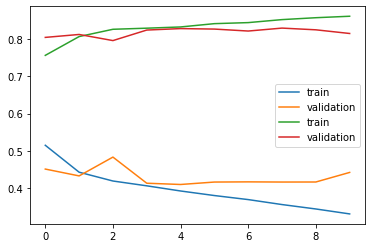

In [162]:
plt.plot(all_train_loss, label='train')
plt.plot(all_valid_loss, label='validation')
plt.legend()
plt.plot(all_train_acc, label='train')
plt.plot(all_valid_acc, label='validation')
plt.legend()

In [163]:
bert_input = convert_df_to_BERT_input(test_data)

[2020-03-27 16:54:21,680][INFO] ## *** Example ***
[2020-03-27 16:54:21,681][INFO] ## idx: 0
[2020-03-27 16:54:21,682][INFO] ## tokens: [ C L S ]   j u s t   h a p p e n e d   t e r r i b l e   c a r   c r a s h   [ S E P ]
[2020-03-27 16:54:21,683][INFO] ## input_ids: 101 2074 3047 6659 2482 5823 102
[2020-03-27 16:54:21,687][INFO] ## segment_ids: 7


In [0]:
data = DataLoader(bert_input)
bert_embeddings = []
with torch.no_grad():
    for index, (input_ids, segment_ids) in enumerate(data):
        tokens_tensor = torch.tensor([input_ids])
        segments_tensors = torch.tensor([segment_ids])
        _, _, hidden_states = bert_model(tokens_tensor, segments_tensors)
        # hidden states length is 13 (1 embedding + 12 hidden layers)
        hidden_layers = hidden_states[1:]
        
        token_vecs = hidden_layers[-1][0]

        # Calculate the average of all token vectors.
        sentence_embedding = torch.mean(token_vecs, dim=0)
        bert_embeddings.append(sentence_embedding)                         

In [165]:
def predict_func(test_data_):
    predictions = []
    data = DataLoader(test_data_)
    for text in data:
        text = text.to(device)
        with torch.no_grad():
            output = model(text)
            predictions.append(output.argmax(1))

    return predictions

predictions = predict_func(bert_embeddings)
print(len(predictions))


3263


In [0]:
def submission(submission_file_path,submission_data):
    sample_submission = pd.read_csv(submission_file_path)
    sample_submission["target"] = [tensor.cpu().numpy()[0] for tensor in submission_data]
    print(sample_submission["target"])
    sample_submission.to_csv("submission.csv", index=False)

In [167]:
submission_file_path = "input/sample_submission.csv"
submission(submission_file_path,predictions)

0       1
1       1
2       1
3       1
4       1
       ..
3258    0
3259    1
3260    1
3261    1
3262    1
Name: target, Length: 3263, dtype: int64
